<a href="https://colab.research.google.com/github/ShivaniGawande/DLFinalProject_Fall22/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, SpatialDropout1D
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
!pip install tokenizers
!pip install transformers
from tokenizers import BertWordPieceTokenizer
import torch
import transformers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.7 MB/s 
     |████████████████████████████████| 182 kB 73.7 MB/s 


In [38]:
#loading data from google drive
'''
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''

#train_file_id = '15NNft0C1CKlKDzjUKbAgibbXTFe8NFgG'
#test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 
'''
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
train_data  = pd.read_csv("train.csv")
train_data.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
df = pd.read_json(url, lines=True)
print(df.head())
     

     label                                           response  \
0  SARCASM  @USER @USER @USER I don't get this .. obviousl...   
1  SARCASM  @USER @USER trying to protest about . Talking ...   
2  SARCASM  @USER @USER @USER He makes an insane about of ...   
3  SARCASM  @USER @USER Meanwhile Trump won't even release...   
4  SARCASM  @USER @USER Pretty Sure the Anti-Lincoln Crowd...   

                                             context  
0  [A minor child deserves privacy and should be ...  
1  [@USER @USER Why is he a loser ? He's just a P...  
2  [Donald J . Trump is guilty as charged . The e...  
3  [Jamie Raskin tanked Doug Collins . Collins lo...  
4  [Man ... y ’ all gone “ both sides ” the apoca...  


In [39]:
df.isna().sum() # Checking for NaN values

label       0
response    0
context     0
dtype: int64

In [40]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


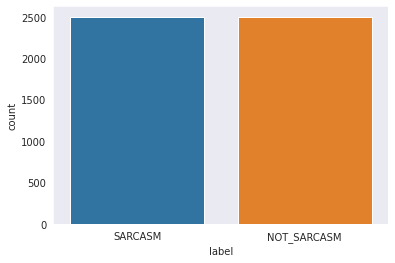

In [41]:
sns.set_style("dark")
sns.countplot(df.label)

In [60]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [71]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['response']=df['response'].apply(denoise_text)

In [85]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = []

for indx, item in enumerate(df.context.values):
  corpus+= get_corpus([df.response[indx]])
  for i in range(0, len(item)):
      corpus+= get_corpus([item[i]])

corpus[:3]

['get', 'obviously', 'care']

In [86]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'@USER': 28324,
 '.': 24671,
 'the': 14806,
 ',': 14365,
 'to': 11811,
 'a': 8853,
 'of': 7748,
 'and': 7651,
 'I': 7318,
 'you': 6553}

In [89]:
X = df[['response','context']]
y = df['label']

In [90]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)

In [97]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [113]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)


In [114]:
x_train = fast_encode(X_train.values, fast_tokenizer,chunk_size=20, maxlen=400)
x_test = fast_encode(X_test.values, fast_tokenizer,chunk_size=20, maxlen=400)

TypeError: ignored

In [ ]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
model = build_model(bert_model, max_len=400)
model.summary()

In [ ]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)


In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(x_test)
pred[:5]

In [ ]:
pred = np.round(pred).astype(int)
pred[:5]

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Test

In [59]:
test = [' Thank goodness ... Power was back on after 16 hours . 😱 😱 😠 Could have been only in 2020 🤣 🤣']
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=100, dtype='int32', value=0)

sentiment = model.predict(test,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

1/1 - 0s - 29ms/epoch - 29ms/step
Non-sarcastic
